In [12]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K 
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, gray2rgb
from skimage.transform import resize
from skimage.io import imsave

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.10.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## VGG16 Model 

- **We will use VGG16 model as a backbone for feature extraction in our (autoencoder) image coloring model.**

- We'll be using first 19 layers of the VGG16 model and ignore the rest of the layers i.e. the fully-connected layers.

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg_model = VGG16()

In [6]:
for layer_number, layer in enumerate(vgg_model.layers):
    print(f"Layer {layer_number}: {layer.name}")

Layer 0: input_1
Layer 1: block1_conv1
Layer 2: block1_conv2
Layer 3: block1_pool
Layer 4: block2_conv1
Layer 5: block2_conv2
Layer 6: block2_pool
Layer 7: block3_conv1
Layer 8: block3_conv2
Layer 9: block3_conv3
Layer 10: block3_pool
Layer 11: block4_conv1
Layer 12: block4_conv2
Layer 13: block4_conv3
Layer 14: block4_pool
Layer 15: block5_conv1
Layer 16: block5_conv2
Layer 17: block5_conv3
Layer 18: block5_pool
Layer 19: flatten
Layer 20: fc1
Layer 21: fc2
Layer 22: predictions


In [3]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Creating our model

In [48]:
from tensorflow.keras.backend import clear_session
clear_session()

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16()
model = models.Sequential(name='image_coloring_autoencoder_model')

# Adding vgg16 layers to our model
for layer_num, layer in enumerate(base_model.layers):
    if layer_num < 19:
        model.add(layer)


# Freezing those layers as we don't want to train them, just feature extracting from learned weights
for layer in model.layers:
    layer.trainable = False
    
model.summary()

Model: "image_coloring_autoencoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None

## Get the Data

In [3]:
# VGG16 expects an image of 3 dimension with size 224x224 as an input

TRAIN_DIR = "../input/train/"
TARGET_SIZE = (224, 224)
BATCH_SZIE=1000


train_datagen = ImageDataGenerator(rescale=1./255)
train = train_datagen.flow_from_directory(TRAIN_DIR,
                                          target_size=TARGET_SIZE,
                                          batch_size=BATCH_SZIE,
                                          class_mode=None)

Found 7129 images belonging to 1 classes.


In [4]:
len(train), train[0].shape

(8, (1000, 224, 224, 3))

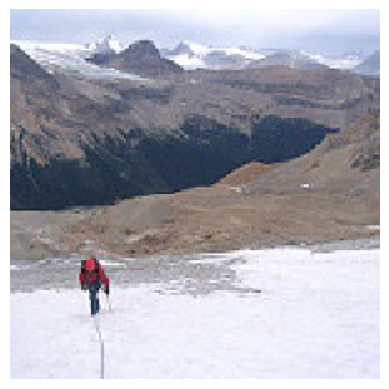

In [5]:
import matplotlib.pyplot as plt

plt.imshow(train[0][0])
plt.axis("off");

## Converting images to `Lab` Color Space

In [6]:
%%time
# "Convert from RGB to Lab: LAB image is a grey image in L channel and all color info stored in A and B channels"


X =[]
Y =[]
for img in train[0]:
    try:
        lab = rgb2lab(img)
        X.append(lab[:,:,0]) 
        Y.append(lab[:,:,1:] / 128) #A and B values range from -127 to 128, 
        #so we divide the values by 128 to restrict values to between -1 and 1.
    except:
        print('error')

X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape+(1,)) #dimensions to be the same for X and Y

print(X.shape)
print(Y.shape)

(1000, 224, 224, 1)
(1000, 224, 224, 2)
CPU times: total: 9.31 s
Wall time: 9.36 s


In [7]:
%%time

#now we have one channel of L in each layer but, VGG16 is expecting 3 dimension, 
#so we repeated the L channel two times to get 3 dimensions of the same L channel
vggfeatures = []
for i, sample in enumerate(X):
    sample = gray2rgb(sample)
    sample = sample.reshape((1,224,224,3))
    prediction = model.predict(sample, verbose=0)
    prediction = prediction.reshape((7,7,512))
    vggfeatures.append(prediction)

vggfeatures = np.array(vggfeatures)
print(vggfeatures.shape)

(1000, 7, 7, 512)
CPU times: total: 33.8 s
Wall time: 1min 10s


In [10]:
#Decoder
decoder_model = models.Sequential()

decoder_model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same', input_shape=(7,7,512)))

decoder_model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
decoder_model.add(layers.UpSampling2D((2, 2)))

decoder_model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
decoder_model.add(layers.UpSampling2D((2, 2)))

decoder_model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
decoder_model.add(layers.UpSampling2D((2, 2)))

decoder_model.add(layers.Conv2D(16, (3,3), activation='relu', padding='same'))
decoder_model.add(layers.UpSampling2D((2, 2)))

decoder_model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
decoder_model.add(layers.UpSampling2D((2, 2)))


decoder_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7, 7, 256)         1179904   
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         295040    
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        73792     
                                                                 
 up_sampling2d_1 (UpSampling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)       

In [11]:
%%time
decoder_model.compile(optimizer='Adam', 
                      loss='mse', 
                      metrics=['accuracy'])


history = decoder_model.fit(vggfeatures, Y, 
                            verbose=1, 
                            epochs=2000, 
                            batch_size=16)

Epoch 1/2000
63/63 [==============================] - 2s 12ms/step - loss: 0.0418 - accuracy: 0.5226
Epoch 2/2000
63/63 [==============================] - 1s 9ms/step - loss: 0.0136 - accuracy: 0.5145
Epoch 3/2000
63/63 [==============================] - 1s 9ms/step - loss: 0.0135 - accuracy: 0.5391
Epoch 4/2000
63/63 [==============================] - 1s 9ms/step - loss: 0.0124 - accuracy: 0.6092
Epoch 5/2000
63/63 [==============================] - 1s 9ms/step - loss: 0.0108 - accuracy: 0.6764
Epoch 6/2000
63/63 [==============================] - 1s 9ms/step - loss: 0.0099 - accuracy: 0.7010
Epoch 7/2000
63/63 [==============================] - 1s 9ms/step - loss: 0.0087 - accuracy: 0.7121
Epoch 8/2000
63/63 [==============================] - 1s 9ms/step - loss: 0.0079 - accuracy: 0.7271
Epoch 9/2000
63/63 [==============================] - 1s 9ms/step - loss: 0.0075 - accuracy: 0.7318
Epoch 10/2000
63/63 [==============================] - 1s 9ms/step - loss: 0.0071 - accuracy: 0.740

In [13]:
K.clear_session()

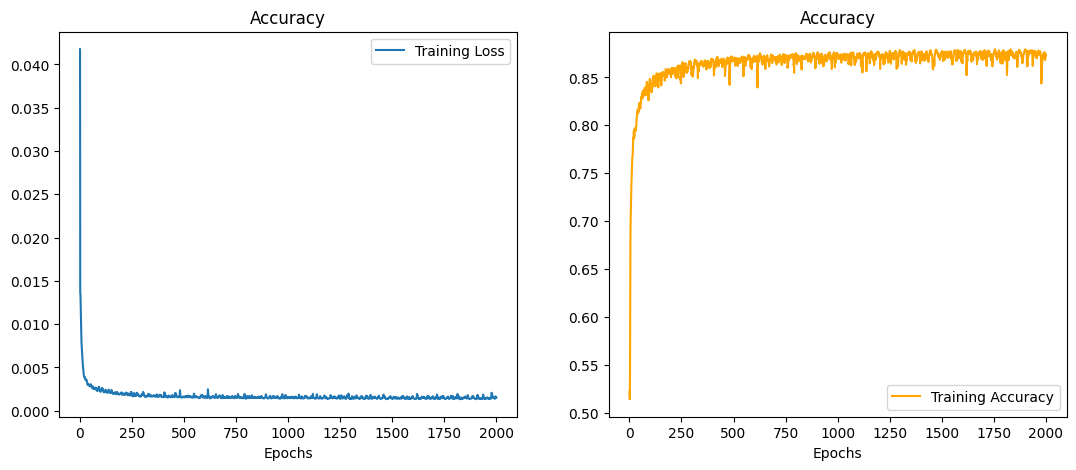

In [34]:
loss = history.history['loss']
accuracy = history.history['accuracy']

epochs = range(1, len(loss)+1)

# Plot loss
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.title("Accuracy")
plt.plot(epochs, loss, label="Training Loss")
plt.xlabel("Epochs")
plt.legend()


# Plot accuracy
plt.subplot(1,2,2)
plt.title("Accuracy")
plt.plot(epochs, accuracy, label="Training Accuracy", color='orange')
plt.xlabel("Epochs")
plt.legend();

In [39]:
os.makedirs("../output/saved_models", exist_ok=True)

decoder_model.save("../output/saved_models/colorize_autoencoder_2000_model")

INFO:tensorflow:Assets written to: ../output/saved_models/colorize_autoencoder_2000_model\assets


INFO:tensorflow:Assets written to: ../output/saved_models/colorize_autoencoder_2000_model\assets


In [40]:
#Predicting using saved model.
loaded_model = tf.keras.models.load_model("../output/saved_models/colorize_autoencoder_2000_model",
                                         custom_objects=None,
                                         compile=True)

In [41]:
testpath = '../input/test/'
files = os.listdir(testpath)
files

['t1.jpg', 't2.jpg', 't3.jpg', 't4.jpg', 't5.jpg']

In [42]:
test = img_to_array(load_img('../input/test/t1.jpg'))

test = resize(test, (224,224), anti_aliasing=True)
test*= 1.0/255

lab = rgb2lab(test)

l = lab[:,:,0]
L = gray2rgb(l)
L = L.reshape((1,224,224,3))

vgg_pred = model.predict(L)
ab = loaded_model.predict(vgg_pred)
ab = ab*128
cur = np.zeros((224, 224, 3))
cur[:,:,0] = l
cur[:,:,1:] = ab

colored_img = lab2rgb(cur)

1/1 [==============================] - 0s 486ms/step


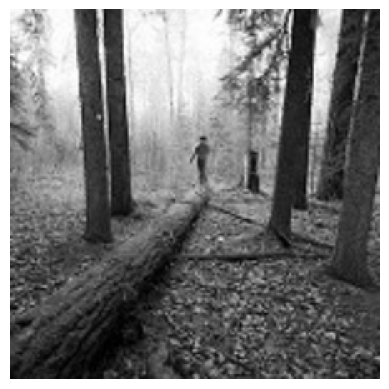

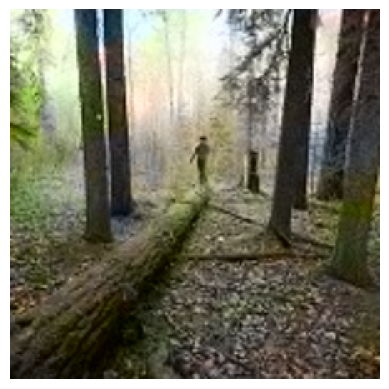

In [46]:
plt.figure()
plt.imshow(test)
plt.axis("off");

plt.figure()
plt.imshow(colored_img)
plt.axis("off");

In [47]:
# for idx, file in enumerate(files):
#     test = img_to_array(load_img(testpath+file))
#     test = resize(test, (224,224), anti_aliasing=True)
#     test*= 1.0/255
#     lab = rgb2lab(test)
#     l = lab[:,:,0]
#     L = gray2rgb(l)
#     L = L.reshape((1,224,224,3))
#     #print(L.shape)
#     vggpred = newmodel.predict(L)
#     ab = model.predict(vggpred)
#     #print(ab.shape)
#     ab = ab*128
#     cur = np.zeros((224, 224, 3))
#     cur[:,:,0] = l
#     cur[:,:,1:] = ab
#     imsave('ImageColoring/MyDrive/ImageColoring/gray/'+str(idx)+".jpg", lab2rgb(cur))